
# End-to-End Time Series Analysis (Hands-On, with Python)

This notebook walks through **everything you can do with a time series**, step by step, using **real datasets**:

**Datasets used**
- **Monthly CO₂** (Mauna Loa) — seasonal + trend (great for decomposition, SARIMA/SARIMAX)
- **Yearly Sunspots** — classic stationary-ish series after transformation (AR/MA/ARMA demos)
- **Quarterly Macrodata** — multivariate (VAR demo)

**We will cover:**
1. Time series basics & components (trend, seasonality, cycle, noise)
2. Loading real datasets
3. Data cleaning (missing values), preparing, indexing, resampling/sampling
4. Lags, shifts, differencing, rolling windows
5. Stationarity (ADF, KPSS), Random Walk vs White Noise
6. ACF/PACF and how to select **p, q, d** (with visuals and scenarios)
7. AR, MA, ARMA, ARIMA
8. Seasonal ARIMA (**SARIMA**)
9. Seasonal ARIMA with exogenous regressors (**SARIMAX**)
10. Vector models (**VAR**)
11. Model selection with **AIC, BIC**
12. Forecasting and interpretation

> Note: All plots use **matplotlib** only (no seaborn) and each chart is drawn in its own figure as requested.


In [1]:

# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Statsmodels for time series
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import VAR

# Reproducibility
rng = np.random.default_rng(42)

# Matplotlib inline setup (works in notebooks)
%matplotlib inline



## 1) Time Series Components

A time series can be decomposed into:
- **Trend**: long-term movement
- **Seasonality**: repeated pattern with fixed frequency
- **Cyclic**: long-term oscillations without fixed period
- **Noise (Irregular)**: random fluctuations

We'll demonstrate decomposition with the **CO₂** dataset which has a clear trend + seasonality.



## 2) Load Real Datasets
We'll load:
- **CO₂ (monthly)** from `statsmodels.datasets.co2`
- **Sunspots (yearly)** from `statsmodels.datasets.sunspots`
- **Macrodata (quarterly)** from `statsmodels.datasets.macrodata`


In [17]:
# Load CO2 dataset (monthly)
co2_raw = sm.datasets.co2.load_pandas().data
# Ensure datetime index and monthly frequency
co2 = co2_raw.copy()
co2['date'] = pd.to_datetime(co2.index)
co2 = co2.set_index('date').asfreq('MS')  # Month Start
co2.rename(columns={'co2': 'CO2'}, inplace=True)

In [20]:
co2.head()

,CO2
date,
1958-04-01,NaN
1958-05-01,NaN
1958-06-01,NaN
1958-07-01,NaN
1958-08-01,NaN


In [18]:
# Load Sunspots (yearly)
sun_raw = sm.datasets.sunspots.load_pandas().data
sun = sun_raw.copy()
sun['YEAR'] = pd.to_datetime(sun['YEAR'], format='%Y')
sun = sun.set_index('YEAR')['SUNACTIVITY'].asfreq('YS').to_frame(name='Sunspots')

In [21]:
sun.head()

,Sunspots
YEAR,
1700-01-01,5.0
1701-01-01,11.0
1702-01-01,16.0
1703-01-01,23.0
1704-01-01,36.0


In [19]:
# Load Macrodata (quarterly)
macro_raw = sm.datasets.macrodata.load_pandas().data
macro = macro_raw.copy()
macro['year'] = macro['year'].astype(int)
macro['quarter'] = macro['quarter'].astype(int)
macro['date'] = pd.PeriodIndex(year=macro['year'], quarter=macro['quarter']).to_timestamp('Q')
macro = macro.set_index('date').asfreq('Q')
macro = macro[['realgdp', 'realcons', 'realinv']].rename(
    columns={'realgdp':'RealGDP', 'realcons':'RealCons', 'realinv':'RealInv'})

/tmp/ipython-input-2648968075.py:6: FutureWarning: Constructing PeriodIndex from fields is deprecated. Use PeriodIndex.from_fields instead.
  macro['date'] = pd.PeriodIndex(year=macro['year'], quarter=macro['quarter']).to_timestamp('Q')
/tmp/ipython-input-2648968075.py:7: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  macro = macro.set_index('date').asfreq('Q')


In [22]:
macro.head()

,RealGDP,RealCons,RealInv
date,,,
1959-03-31,2710.349,1707.4,286.898
1959-06-30,2778.801,1733.7,310.859
1959-09-30,2775.488,1751.8,289.226
1959-12-31,2785.204,1753.7,299.356
1960-03-31,2847.699,1770.5,331.722



## 3) Data Cleaning & Preparation

- **Missing values**: we will check and **forward-fill (ffill)** where appropriate.
- **Indexing & frequency**: ensure DateTimeIndex with regular frequency.
- **Sampling / Resampling**: show how to change granularity (e.g., from monthly to quarterly).


In [23]:
# Missing values check
print("Missing in CO2:", co2['CO2'].isna().sum())
print("Missing in Sunspots:", sun['Sunspots'].isna().sum())
print("Missing in Macro (any):", macro.isna().sum().to_dict())

Missing in CO2: 454
Missing in Sunspots: 0
Missing in Macro (any): {'RealGDP': 0, 'RealCons': 0, 'RealInv': 0}


In [24]:
# Clean CO2 with forward-fill (propagate last valid observation forward)
co2_clean = co2.copy()
co2_clean['CO2'] = co2_clean['CO2'].fillna(method='ffill')

/tmp/ipython-input-3702013030.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  co2_clean['CO2'] = co2_clean['CO2'].fillna(method='ffill')


In [25]:
print("\nAfter ffill, missing in CO2:", co2_clean['CO2'].isna().sum())


After ffill, missing in CO2: 16


In [26]:
# Resample CO2 monthly -> quarterly mean as an example
co2_q = co2_clean['CO2'].resample('Q').mean().to_frame(name='CO2_Q')

/tmp/ipython-input-1658802326.py:2: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  co2_q = co2_clean['CO2'].resample('Q').mean().to_frame(name='CO2_Q')


In [27]:
co2_clean.head()

,CO2
date,
1958-04-01,NaN
1958-05-01,NaN
1958-06-01,NaN
1958-07-01,NaN
1958-08-01,NaN


In [28]:
co2_q.head()

,CO2_Q
date,
1958-06-30,NaN
1958-09-30,NaN
1958-12-31,NaN
1959-03-31,NaN
1959-06-30,NaN


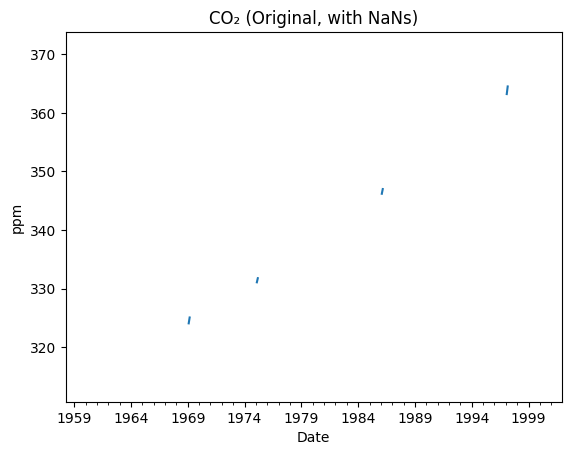

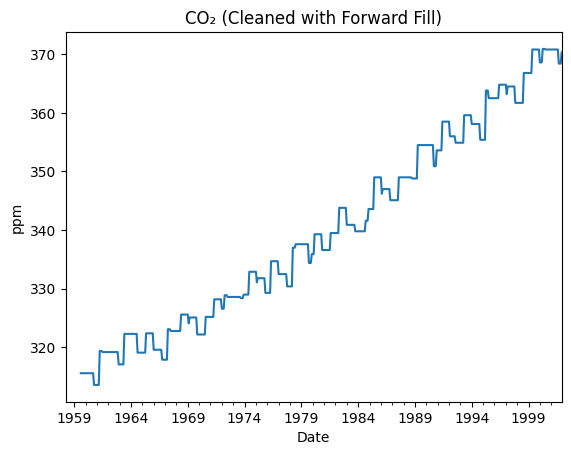

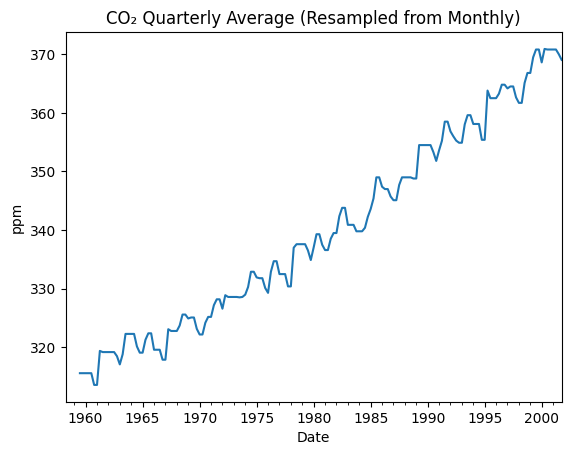

In [29]:

# Visualize original vs cleaned CO2
plt.figure()
co2['CO2'].plot(title='CO₂ (Original, with NaNs)')
plt.xlabel('Date'); plt.ylabel('ppm')
plt.show()

plt.figure()
co2_clean['CO2'].plot(title='CO₂ (Cleaned with Forward Fill)')
plt.xlabel('Date'); plt.ylabel('ppm')
plt.show()

plt.figure()
co2_q['CO2_Q'].plot(title='CO₂ Quarterly Average (Resampled from Monthly)')
plt.xlabel('Date'); plt.ylabel('ppm')
plt.show()



## 4) Lags, Shifts, Differencing, Rolling Windows

- **Lag/Shift**: `series.shift(1)` aligns past values to compare with current.
- **Differencing**: `series.diff()` removes trend (or seasonal diff with `diff(s)`).
- **Rolling windows**: moving averages/variances to smooth and inspect stability.


In [31]:
# Use CO2 for examples
s = co2_clean['CO2']

In [32]:
lag1 = s.shift(1)
diff1 = s.diff(1)              # first difference
diff12 = s.diff(12)            # seasonal difference (12 months)
roll_mean_12 = s.rolling(12).mean()
roll_std_12 = s.rolling(12).std()

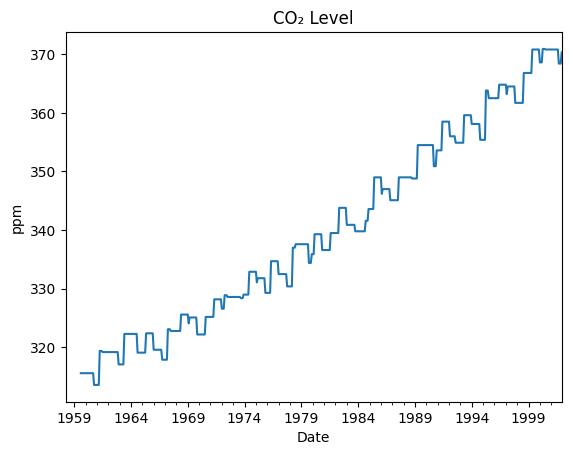

In [35]:
plt.figure()
s.plot(title='CO₂ Level')
plt.xlabel('Date'); plt.ylabel('ppm')
plt.show()


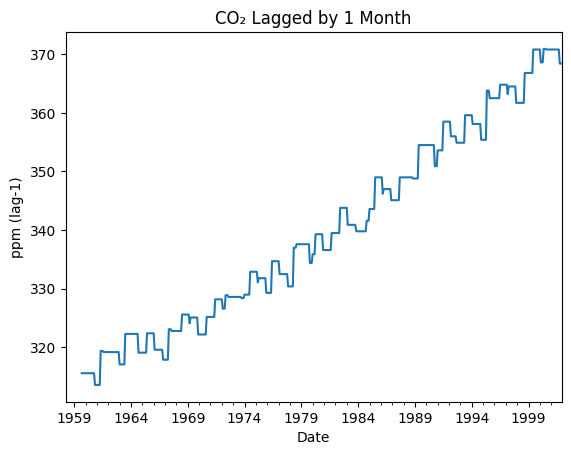

In [36]:
plt.figure()
lag1.plot(title='CO₂ Lagged by 1 Month')
plt.xlabel('Date'); plt.ylabel('ppm (lag-1)')
plt.show()

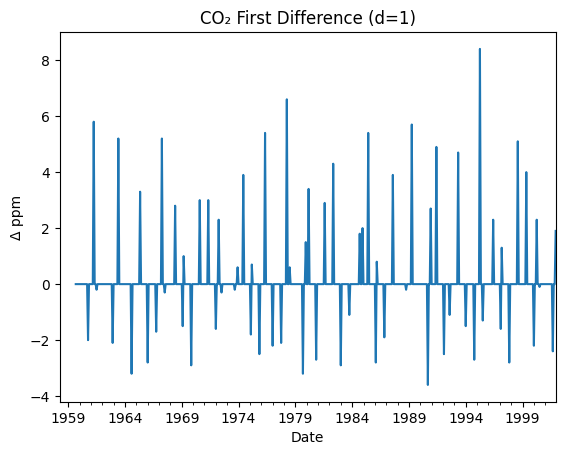

In [37]:
plt.figure()
diff1.plot(title='CO₂ First Difference (d=1)')
plt.xlabel('Date'); plt.ylabel('Δ ppm')
plt.show()

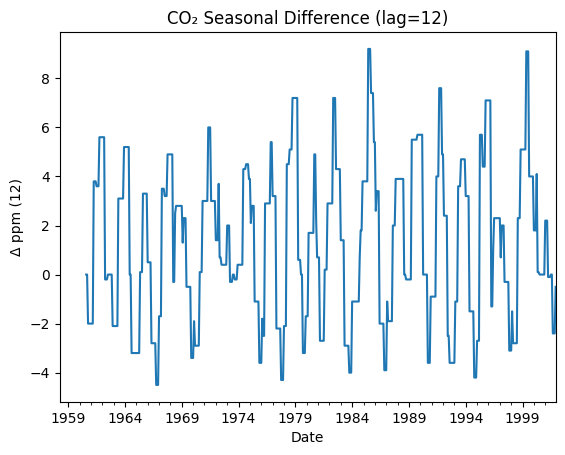

In [38]:
plt.figure()
diff12.plot(title='CO₂ Seasonal Difference (lag=12)')
plt.xlabel('Date'); plt.ylabel('Δ ppm (12)')
plt.show()

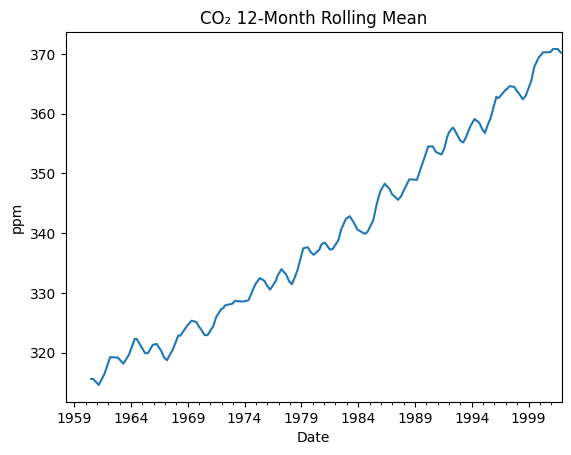

In [39]:
plt.figure()
roll_mean_12.plot(title='CO₂ 12-Month Rolling Mean')
plt.xlabel('Date'); plt.ylabel('ppm')
plt.show()

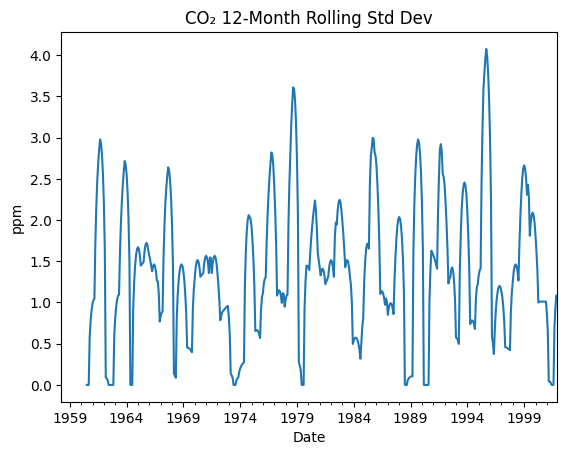

In [40]:
plt.figure()
roll_std_12.plot(title='CO₂ 12-Month Rolling Std Dev')
plt.xlabel('Date'); plt.ylabel('ppm')
plt.show()


## 5) Stationarity: ADF & KPSS, Random Walk vs White Noise

- **ADF (Augmented Dickey-Fuller)**: H₀ = **unit root (non-stationary)**. Small p-value ⇒ reject H₀ ⇒ stationary.
- **KPSS (Kwiatkowski–Phillips–Schmidt–Shin)**: H₀ = **stationary**. Small p-value ⇒ reject H₀ ⇒ non-stationary.
- **Random Walk**: non-stationary; differencing makes it stationary.
- **White Noise**: zero-mean iid noise; stationary.


In [41]:
def adf_test(x, name="series"):
    x = x.dropna()
    res = adfuller(x, autolag='AIC')
    out = {
        'Test': 'ADF',
        'Series': name,
        'Statistic': res[0],
        'pvalue': res[1],
        'lags': res[2],
        'nobs': res[3],
        'crit': res[4]
    }
    return out

In [42]:
def kpss_test(x, name="series", regression='c', nlags='auto'):
    x = x.dropna()
    res = kpss(x, regression=regression, nlags=nlags)
    out = {
        'Test': 'KPSS',
        'Series': name,
        'Statistic': res[0],
        'pvalue': res[1],
        'lags': res[2]
    }
    return out

In [43]:
# Tests on CO2 (level, differenced)
tests = []
tests.append(adf_test(co2_clean['CO2'], 'CO2 (level)'))
tests.append(kpss_test(co2_clean['CO2'], 'CO2 (level)'))

/tmp/ipython-input-2987743937.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  res = kpss(x, regression=regression, nlags=nlags)


In [44]:
tests.append(adf_test(co2_clean['CO2'].diff(1), 'CO2 (diff 1)'))
tests.append(kpss_test(co2_clean['CO2'].diff(1).dropna(), 'CO2 (diff 1)'))

/tmp/ipython-input-2987743937.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  res = kpss(x, regression=regression, nlags=nlags)


In [45]:
tests.append(adf_test(co2_clean['CO2'].diff(12), 'CO2 (diff 12)'))
tests.append(kpss_test(co2_clean['CO2'].diff(12).dropna(), 'CO2 (diff 12)'))

/tmp/ipython-input-2987743937.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  res = kpss(x, regression=regression, nlags=nlags)


In [46]:
pd.DataFrame(tests)

,Test,Series,Statistic,pvalue,lags,nobs,crit
0,ADF,CO2 (level),0.608174,9.878154e-01,19,489.0,"{'1%': -3.4437936797256317, '5%': -2.867468682..."
1,KPSS,CO2 (level),3.686471,1.000000e-02,13,NaN,NaN
2,ADF,CO2 (diff 1),-9.634230,1.582268e-16,17,490.0,"{'1%': -3.4437660979098843, '5%': -2.867456546..."
3,KPSS,CO2 (diff 1),0.025821,1.000000e-01,5,NaN,NaN
4,ADF,CO2 (diff 12),-5.552571,1.607431e-06,14,482.0,"{'1%': -3.4439899743408136, '5%': -2.867555055..."
5,KPSS,CO2 (diff 12),0.067325,1.000000e-01,12,NaN,NaN


In [47]:
# Simulate white noise and random walk for intuition
n = 400
wn = rng.normal(0, 1, size=n)
rw = np.cumsum(rng.normal(0, 1, size=n))

In [48]:
wn_s = pd.Series(wn, index=pd.date_range('2000-01-01', periods=n, freq='D'), name='WhiteNoise')
rw_s = pd.Series(rw, index=pd.date_range('2000-01-01', periods=n, freq='D'), name='RandomWalk')

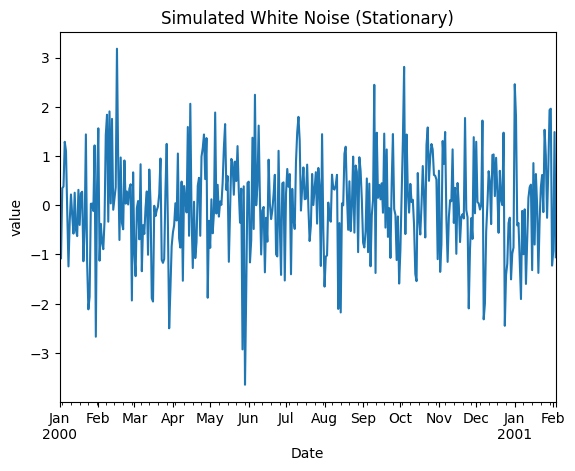

In [49]:
plt.figure()
wn_s.plot(title='Simulated White Noise (Stationary)')
plt.xlabel('Date'); plt.ylabel('value')
plt.show()

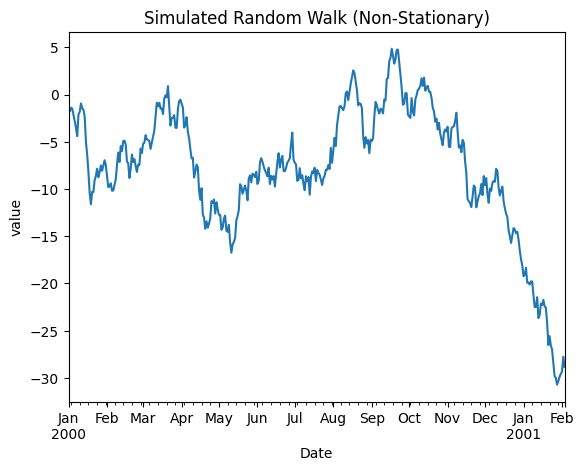

In [50]:
plt.figure()
rw_s.plot(title='Simulated Random Walk (Non-Stationary)')
plt.xlabel('Date'); plt.ylabel('value')
plt.show()

In [51]:
print('ADF p-values:')
print('White Noise:', adf_test(wn_s)['pvalue'])
print('Random Walk:', adf_test(rw_s)['pvalue'])


ADF p-values:
White Noise: 2.7718937378285687e-30
Random Walk: 0.9459074746270913



## 6) ACF & PACF — Choosing p, q, d

**Heuristics:**
- If series is non-stationary → apply differencing (choose **d**).
- **AR(p)**: PACF cuts off after lag *p*, ACF tails off.
- **MA(q)**: ACF cuts off after lag *q*, PACF tails off.
- **ARMA(p,q)**: both ACF and PACF tail off.

We'll use **Sunspots** (after transformation if needed) and **CO₂ (differenced)** for demos.


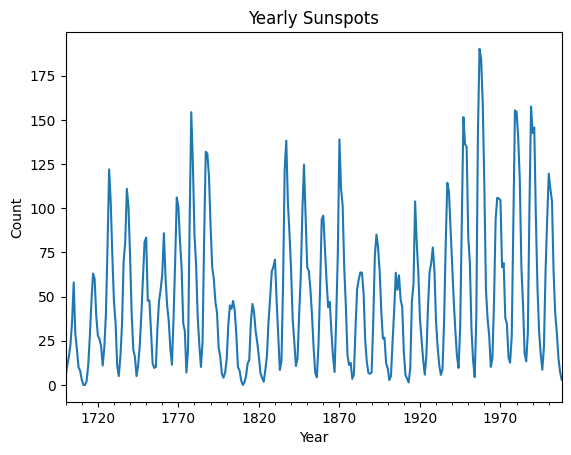

In [52]:
# Sunspots: visualize and ACF/PACF
plt.figure()
sun['Sunspots'].plot(title='Yearly Sunspots')
plt.xlabel('Year'); plt.ylabel('Count')
plt.show()

In [53]:
# Optional transform (stabilize variance) - log(1+x)
sun_t = np.log1p(sun['Sunspots'])

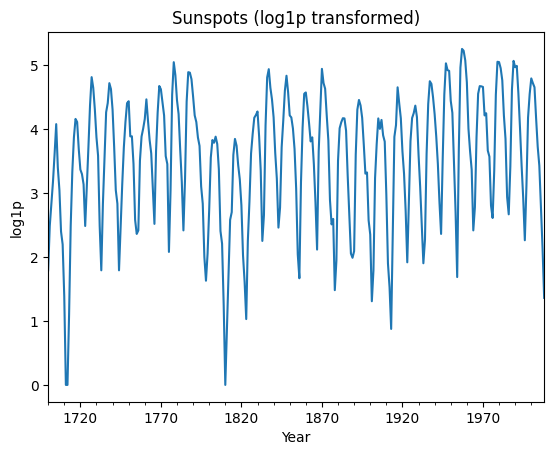

In [54]:
plt.figure()
sun_t.plot(title='Sunspots (log1p transformed)')
plt.xlabel('Year'); plt.ylabel('log1p')
plt.show()

<Figure size 640x480 with 0 Axes>

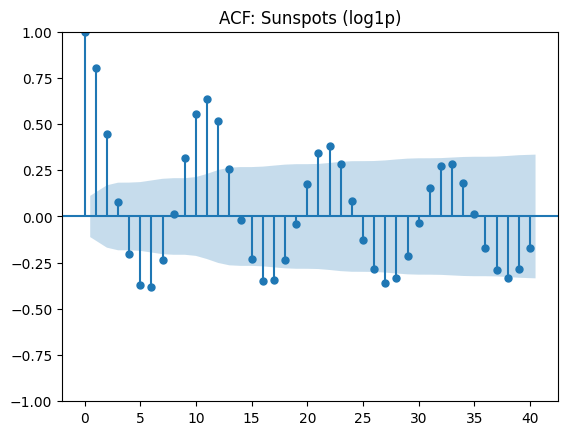

In [55]:
plt.figure()
plot_acf(sun_t.dropna(), lags=40)
plt.title('ACF: Sunspots (log1p)')
plt.show()

<Figure size 640x480 with 0 Axes>

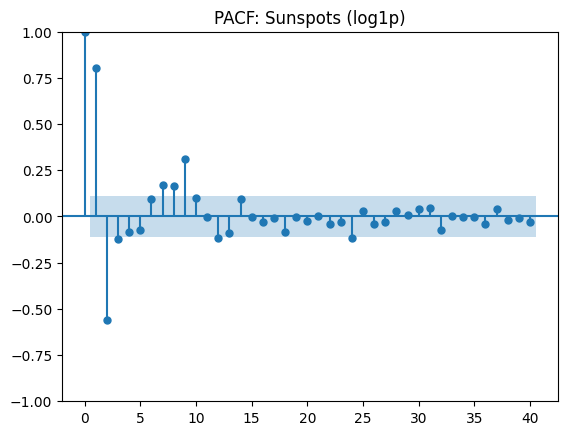

In [56]:
plt.figure()
plot_pacf(sun_t.dropna(), lags=40, method='ywm')
plt.title('PACF: Sunspots (log1p)')
plt.show()


In [57]:
# CO2 differenced for stationarity (seasonal & regular differencing)
co2_d = co2_clean['CO2'].diff(12).diff(1).dropna()

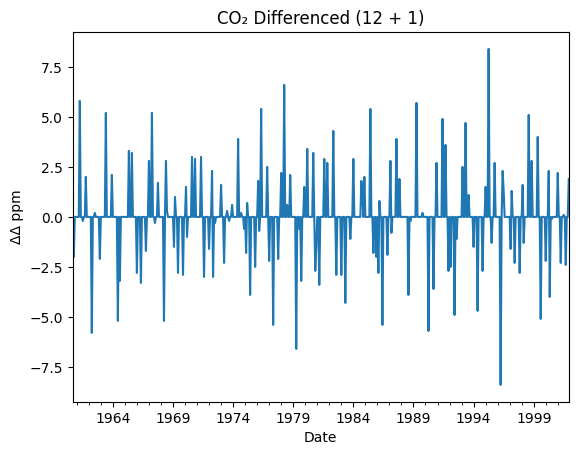

In [58]:
plt.figure()
co2_d.plot(title='CO₂ Differenced (12 + 1)')
plt.xlabel('Date'); plt.ylabel('ΔΔ ppm')
plt.show()

<Figure size 640x480 with 0 Axes>

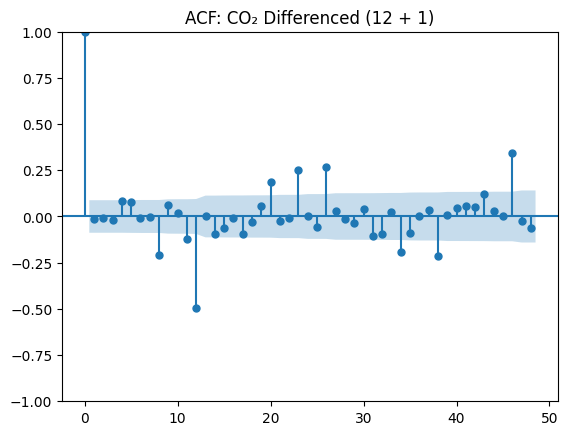

In [59]:
plt.figure()
plot_acf(co2_d, lags=48)
plt.title('ACF: CO₂ Differenced (12 + 1)')
plt.show()

<Figure size 640x480 with 0 Axes>

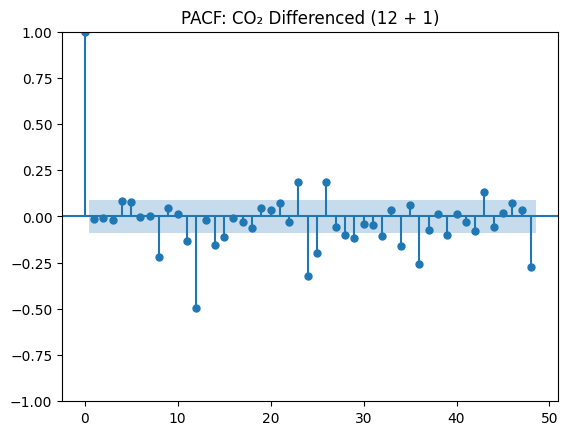

In [60]:
plt.figure()
plot_pacf(co2_d, lags=48, method='ywm')
plt.title('PACF: CO₂ Differenced (12 + 1)')
plt.show()



## 7) AR, MA, ARMA, ARIMA (Univariate)

We'll fit a few models and compare using AIC/BIC:
- **AR(p)** and **MA(q)** via `ARIMA` by setting appropriate orders
- **ARMA(p,q)** via `ARIMA(order=(p,0,q))`
- **ARIMA(p,d,q)** with differencing


In [61]:
# Example: Sunspots (log1p) - try ARIMA models with different (p,d,q)
y = sun_t.dropna()

In [62]:
orders = [(1,0,0), (0,0,1), (1,0,1), (2,0,2), (2,1,2)]
rows = []

In [63]:
for order in orders:
    try:
        model = ARIMA(y, order=order)
        res = model.fit()
        rows.append({'order': order, 'AIC': res.aic, 'BIC': res.bic})
    except Exception as e:
        rows.append({'order': order, 'AIC': np.nan, 'BIC': np.nan})

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [64]:
pd.DataFrame(rows).sort_values('AIC')

,order,AIC,BIC
4,"(2, 1, 2)",411.207613,429.858112
3,"(2, 0, 2)",433.625103,456.025150
2,"(1, 0, 1)",482.049964,496.983329
0,"(1, 0, 0)",569.041057,580.241081
1,"(0, 0, 1)",627.481817,638.681840


In [65]:
# Fit the best (by AIC) and visualize in-sample fit
best_order = sorted(rows, key=lambda r: r['AIC'] if not np.isnan(r['AIC']) else np.inf)[0]['order']
best_model = ARIMA(y, order=best_order).fit()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


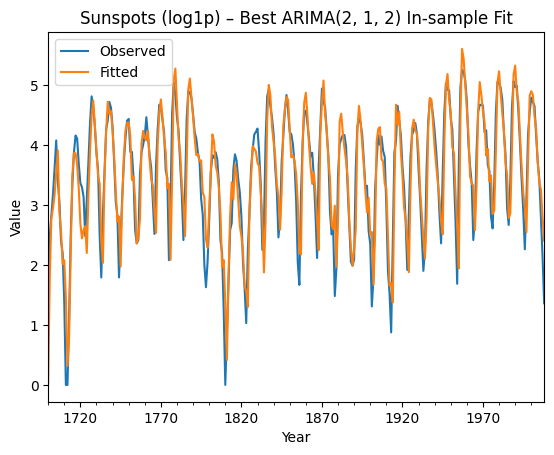

In [66]:
plt.figure()
y.plot(label='Observed', title=f'Sunspots (log1p) – Best ARIMA{best_order} In-sample Fit')
pd.Series(best_model.fittedvalues, index=y.index).plot(label='Fitted')
plt.legend()
plt.xlabel('Year'); plt.ylabel('Value')
plt.show()

In [67]:
# Forecast next 10 years
fc = best_model.get_forecast(steps=10)
fc_mean = fc.predicted_mean
fc_ci = fc.conf_int()

<Axes: title={'center': 'Sunspots (log1p) – Forecast (ARIMA(2, 1, 2))'}, xlabel='YEAR'>

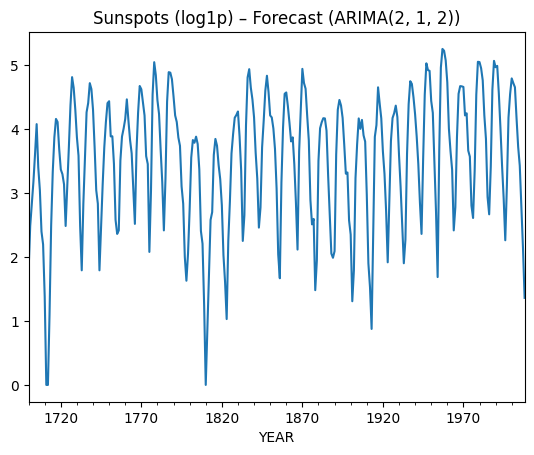

In [68]:
plt.figure()
y.plot(label='Observed', title=f'Sunspots (log1p) – Forecast (ARIMA{best_order})')

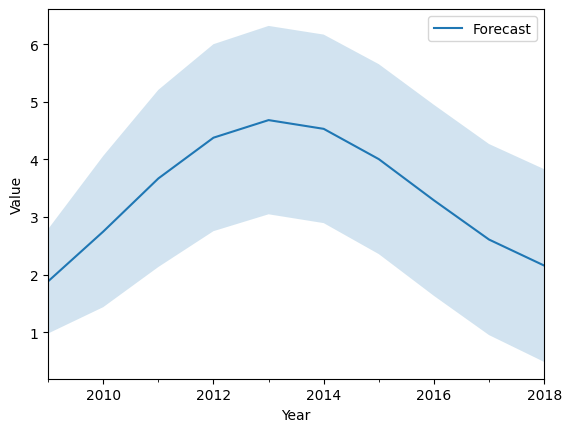

In [69]:
fc_mean.plot(label='Forecast')
plt.fill_between(fc_ci.index, fc_ci.iloc[:,0], fc_ci.iloc[:,1], alpha=0.2)
plt.legend()
plt.xlabel('Year'); plt.ylabel('Value')
plt.show()


## 8) Seasonal ARIMA (SARIMA)
CO₂ is monthly with seasonality (12). We'll try:
- **SARIMA(p,d,q)×(P,D,Q, s=12)**


In [71]:
# Prepare CO2 series (log to stabilize variance, then seasonal differencing idea)
y_co2 = np.log(co2_clean['CO2']).dropna()

In [72]:
# Try a few SARIMA orders and compare by AIC
sarima_orders = [
    ((1,1,1),(1,1,1,12)),
    ((2,1,1),(1,1,1,12)),
    ((1,1,2),(1,1,1,12)),
    ((0,1,1),(0,1,1,12)),
]

In [73]:
rows = []
results = {}

In [74]:
for (p,d,q), (P,D,Q,s) in sarima_orders:
    try:
        m = SARIMAX(y_co2, order=(p,d,q), seasonal_order=(P,D,Q,s), enforce_stationarity=False, enforce_invertibility=False)
        r = m.fit(disp=False)
        key = f"({p},{d},{q})x({P},{D},{Q},{s})"
        results[key] = r
        rows.append({'order': key, 'AIC': r.aic, 'BIC': r.bic})
    except Exception as e:
        rows.append({'order': key, 'AIC': np.nan, 'BIC': np.nan})

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [75]:
sarima_compare = pd.DataFrame(rows).sort_values('AIC')
sarima_compare

,order,AIC,BIC
0,"(1,1,1)x(1,1,1,12)",-4103.429174,-4082.539453
2,"(1,1,2)x(1,1,1,12)",-4091.827244,-4066.772040
3,"(0,1,1)x(0,1,1,12)",-4045.990447,-4033.456614
1,"(2,1,1)x(1,1,1,12)",-3998.359072,-3973.291407


In [77]:
# Pick best SARIMA by AIC
best_key = sarima_compare.iloc[0]['order']
best_sarima = results[best_key]

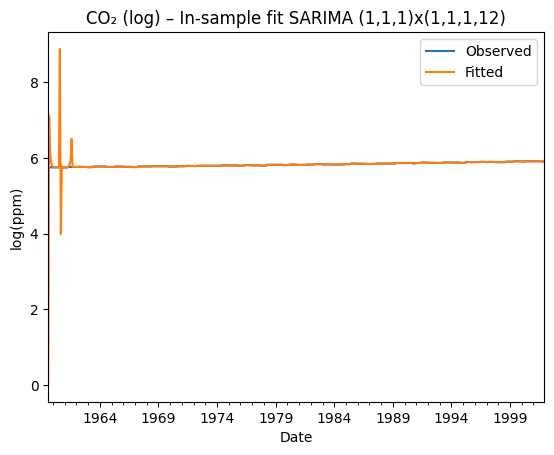

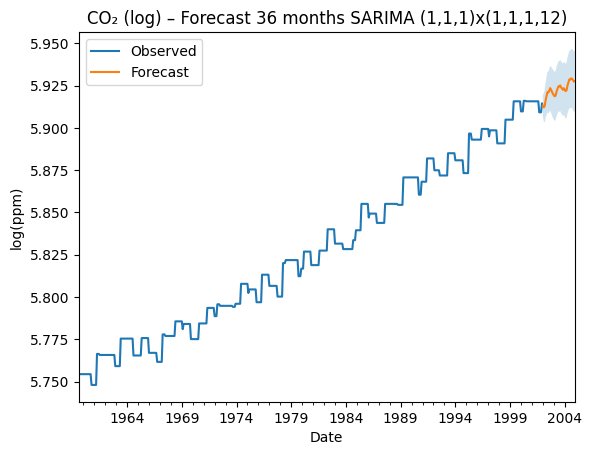

In [80]:
plt.figure()
y_co2.plot(label='Observed', title=f'CO₂ (log) – In-sample fit SARIMA {best_key}')
pd.Series(best_sarima.fittedvalues, index=y_co2.index).plot(label='Fitted')
plt.legend()
plt.xlabel('Date'); plt.ylabel('log(ppm)')
plt.show()

# Forecast 36 months ahead
fc = best_sarima.get_forecast(steps=36)
fc_mean = fc.predicted_mean
fc_ci = fc.conf_int()

plt.figure()
y_co2.plot(label='Observed', title=f'CO₂ (log) – Forecast 36 months SARIMA {best_key}')
fc_mean.plot(label='Forecast')
plt.fill_between(fc_ci.index, fc_ci.iloc[:,0], fc_ci.iloc[:,1], alpha=0.2)
plt.legend()
plt.xlabel('Date'); plt.ylabel('log(ppm)')
plt.show()



## 9) Vector Autoregression (VAR)

For **multivariate** time series, we can capture interactions across variables.
We'll use **Macrodata** with `RealGDP`, `RealCons` (consumption), and `RealInv` (investment).

Steps:
1. Make series stationary (e.g., take log and difference).
2. Select lag order by AIC/BIC.
3. Fit VAR and forecast.


 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -27.72      -27.67   9.157e-13      -27.70
1       -28.05     -27.84*   6.596e-13     -27.96*
2       -28.05      -27.69   6.594e-13      -27.90
3      -28.06*      -27.54  6.542e-13*      -27.85
4       -28.04      -27.37   6.640e-13      -27.77
5       -28.03      -27.21   6.741e-13      -27.69
6       -27.98      -27.00   7.101e-13      -27.58
7       -27.94      -26.81   7.365e-13      -27.48
8       -27.94      -26.66   7.376e-13      -27.42
9       -27.97      -26.53   7.191e-13      -27.39
10      -27.93      -26.34   7.498e-13      -27.28
11      -27.87      -26.12   7.988e-13      -27.16
12      -27.84      -25.94   8.271e-13      -27.07
--------------------------------------------------
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 23, Aug

/tmp/ipython-input-2989714940.py:21: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  fc_index = pd.date_range(macro_d.index[-1] + pd.offsets.QuarterEnd(), periods=8, freq='Q')


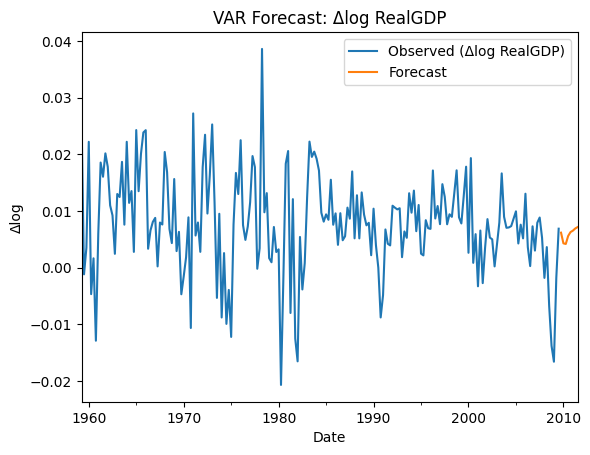

In [15]:

# Prepare macro data: take logs and first differences (to induce stationarity)
macro_log = np.log(macro[['RealGDP','RealCons','RealInv']])
macro_d = macro_log.diff().dropna()

# Select lag order
model_var = VAR(macro_d)
lag_order_results = model_var.select_order(maxlags=12)
print(lag_order_results.summary())

# Fit with the lag minimizing AIC
best_lag = lag_order_results.aic
# lag_order_results.aic returns the integer lag, but sometimes it's None; handle safely
if best_lag is None or (isinstance(best_lag, float) and np.isnan(best_lag)):
    best_lag = 4

res_var = model_var.fit(int(best_lag))
print(res_var.summary())

# Forecast 8 steps ahead
fc = res_var.forecast(macro_d.values[-int(best_lag):], steps=8)
fc_index = pd.date_range(macro_d.index[-1] + pd.offsets.QuarterEnd(), periods=8, freq='Q')
fc_df = pd.DataFrame(fc, index=fc_index, columns=macro_d.columns)

# Plot forecasts (differenced logs). For clarity, only plot RealGDP
plt.figure()
pd.Series(macro_d['RealGDP'], index=macro_d.index).plot(label='Observed (Δlog RealGDP)', title='VAR Forecast: Δlog RealGDP')
pd.Series(fc_df['RealGDP'], index=fc_df.index).plot(label='Forecast')
plt.legend()
plt.xlabel('Date'); plt.ylabel('Δlog')
plt.show()



## 10) Model Selection: AIC & BIC

- **AIC = 2k - 2\ln(L)** where *k* is number of parameters, *L* is likelihood.
- **BIC = k\ln(n) - 2\ln(L)** penalizes complexity more strongly than AIC.
- **Lower AIC/BIC** ⇒ better balance of fit vs complexity.

We'll summarize AIC/BIC across candidate models we tried above.


In [16]:

# Collect and summarize model selection comparisons already computed
print("SARIMA comparison (by AIC):")
display(sarima_compare)

print("\nSunspots ARIMA candidate orders (sorted by AIC):")
display(pd.DataFrame([r for r in rows if not np.isnan(r['AIC'])]).sort_values('AIC'))


SARIMA comparison (by AIC):


,order,AIC,BIC
0,"(1,1,1)x(1,1,1,12)",-4103.429174,-4082.539453
2,"(1,1,2)x(1,1,1,12)",-4091.827244,-4066.772040
3,"(0,1,1)x(0,1,1,12)",-4045.990447,-4033.456614
1,"(2,1,1)x(1,1,1,12)",-3998.359072,-3973.291407



Sunspots ARIMA candidate orders (sorted by AIC):


,order,AIC,BIC
0,"(1,1,1)x(1,1,1,12)",-4103.429174,-4082.539453
2,"(1,1,2)x(1,1,1,12)",-4091.827244,-4066.772040
3,"(0,1,1)x(0,1,1,12)",-4045.990447,-4033.456614
1,"(2,1,1)x(1,1,1,12)",-3998.359072,-3973.291407



## 11) Wrap-Up & Practical Tips

- Always **visualize** raw series first to spot trends/seasonality/outliers.
- Check **stationarity** using both ADF and KPSS (they test opposite nulls).
- Use **ACF/PACF** to guide (p, q) and **d** via differencing; consider seasonal differencing for strong seasonal patterns.
- Compare models using **AIC/BIC**, then validate with **residual diagnostics**.
- For **seasonal data**, try **SARIMA** or **SARIMAX** (with Fourier terms or external regressors).
- For **multivariate** problems, consider **VAR**; ensure all series are stationary (logs + differencing help).
- Always evaluate **forecast accuracy** (RMSE/MAE) on a hold-out set if possible.
